<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



## Introduction

H.264 is a highly common video compression technique that is widely used with the common and well known format of .mp4. In this project, we implement a fully working encoder and decoder for the H.264 technique. In order to explore our results, we compare different compression rates by choosing how many reference frames to choose which shall give different video qualities that degenerate at high compression rates. Throught the paper, we use a block_size of 16 x 16 for the reference frames to carry out the motion estimation and compensation (predicting frames). Although the code is modular and can work with any given block size, we have chosen 16 x 16 to be our test case. 


In [7]:
from matplotlib import pyplot as plt
import cv2
import Main as M
from IPython.display import Video # To display the video in the notebook
import numpy as np
import timeit

In [8]:
# Play the video
Video("mountain.mp4")

## Video Compression

This diagram represents the encoding process. There are 2 main models in this scheme, namely, temporal and spatial models. Temporal being the time component which is where we find the highest redundancy and where lies most of the potential for compression. Leveraging the redundancy in adjacent frames in a smart and efficient way can provide high compression capabilities with little damage to the data. On the other hand, the spatial model offers yet another way to compress the data even further. Shown below is the block diagram used to implement the video compression. (Reference to H.264 and MPEG 4 Video Compression book by Iain Richardson) ![video_compression pipeline diagram](images/block_diagram.jpg)

## Methodology

In the following blocks of code, different parameters of encoding are going to be used to explore the gains and draws of these changes. The first parameter controls the accuracy of the residuals by employing a technique called subpixel estimation. This technique theoretically works by tracking the changes within the pixel itself. The second paramter controls the efficiency of this compression method by using a single reference for multiple predicted images. The output bitstream due to these parameters are then saved in Encoded_BitStream which is what we use to calculate the compression ratio of the algorithm.

To encode and decode, 2 main functions in Main.py were utilized; namely, encode() and decode(). Both functions arrange all encoder.py and decoder.py functions sequentially in the following way:


### Encoding

#### Theory:
Video compression in general works by, instead of encoding the whole video frames and sending the encoding data, info about the video that would aid in the regeneration of the video itself is encoded. This info in the case of H264 compression, which is implemented in the code below, is represented through motion vectors and residuals. Motion vectors provides inforamtion about how each element in the reference frame moves with respect to a future frame. This matrix is calculated by taking a block from the reference frame and searching for that same block in the future frame and calculating the change in index between these 2 blocks. This information combined with the full reference frame can provide a prediction of that future frame by moving the elements of the reference frame by the values presented in the motion vector matrix. The predicted future image is then subtracted from the actual future frame to calculate the residual frame. This method is desirable as the energy present in these matricies are lower than that in the full frame.

![Motion vector diagram](images/Motion_Vectors.gif)</br>


#### Implementation:

1. The video frames are extracted and converted to luma and chroma components from the original RGB.
2. A reference frame is taken every given number of frames.
3. All the frames are broken into blocks to be easily used in the functions to come.
4. Motion vectors are then calculated using the reference frame and the current frame luma components.
5. New motion vector is then calculated from the old motion vectors to account for chroma components.
6. 3 predicted predicted images (luma and 2 chroma components) are then calculated by moving the blocks according to the motion vector.
7. Residuals are then calculated by subtracting the predicted frame from the actual current frame.
8. The residuals calculated are then passed into a spatial model function which applies DCT and quantization functions on the image.
9. The output of the spatial model ,motion vectors and reference frames are then binarized
10. Finally the bitstream from the previous step is then given through the BAC (binary arithmetic encoder)


### Decoding

#### Theory
A process similar to the encoder is also done in the decoder. A predicted image is calculated using the motion vectors and reference frames decoded from the bit stream. The predicted image is then added to the residuals that are also decoded from the input bitstream. The residuals are passed through an inverse spatial model before being added to the predicted images.

#### Implementation

1. The input bitstream is decoded using binary arithmetic decoder
2. The decoded bitstream is then debinarized to give the residuals, motion vectors and reference frames
3. Motion Vectors are applied to the reference frames to output the predicted image
4. Residual matricies are passed through an inverse spatial model
5. The reconstructed image is given by adding the residuals to the predicted image

## Process the video

In [9]:
# Resolution specifies the depth of the subpixel motion estimation. 
# Resolution 1 means there is not subpixel motion estimation. 
# no_frames specifies the number of frames to be encoded. The first frame will be a reference frame, and the 4 frames will be predicted frames
#Resolution = 1
#no_frames = 5
#start = timeit.default_timer()
#BitStream=M.encode("mountain.mp4",5Resolution)
#OutputVideo=M.decode(Encoded_BitStream,5,Resolution)
#print("Execution time: ", timeit.default_timer() - start)

## Encode the video

In [10]:
import julia 
import Encoder as E
jl = julia.Julia()
jl.include('bac.jl')
jl.include('motion_estimation.jl')
path="mountain.mp4"
predictedPerRef=3 
no_frames = 5
Resolution=1
vid_frame=E.get_video_frames(path,no_frames,Resolution)
vid_frame=E.interlace_comp_frames(vid_frame)
ref_frames=vid_frame[::predictedPerRef]
n_predicted_frames = no_frames - int(np.ceil(len(vid_frame)/predictedPerRef))
residual_frames_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
residual_frames_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
residual_frames_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)

vid_mv = np.zeros((n_predicted_frames, int(vid_frame[0][0].shape[0]/16), int(vid_frame[0][0].shape[1]/16), 2), dtype = int)
c=1
for j in range(0,int(np.ceil(len(vid_frame)/predictedPerRef))):

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)


    for i in range(0,predictedPerRef-1):
        #print(ref_frames[j][0])
        #Reshaping the current frame 
        current_im_blocks, nrows, ncols = E.get_sub_images(E.reshape_image(vid_frame[c][0]))

        #Motion estimation 
        mv = jl.motion_estimation_to_all(ref_frames[j][0], current_im_blocks, nrows, ncols)
        print(j)

        #Motion Compensation
        p_image_y = E.predict(im_ref_y,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1],16)
        mv_cb=np.zeros(mv.shape,dtype=int)
        for x in range(mv.shape[0]):
            for z in range(mv.shape[1]):
                mv_cb[x][z][0]=np.int(mv[x][z][0]/2)
                mv_cb[x][z][1]=np.int(mv[x][z][1]/2)

        p_image_cb=E.predict(im_ref_cb,mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1],8)
        p_image_cr=E.predict(im_ref_cr,mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1],8)

        #Calculating the residuals
        res_index = int(c - np.ceil(j/predictedPerRef) - 1)
        residual_frames_y[res_index]=E.residual(vid_frame[c][0],p_image_y)
        residual_frames_cb[res_index]=E.residual(vid_frame[c][1],p_image_cb)
        residual_frames_cr[res_index]=E.residual(vid_frame[c][2],p_image_cr)
        
        vid_mv[res_index] = mv
        c+=1
        if(c>len(vid_frame)-1):
            break
    c+=1

# Spatial model
quantized_coeff_y = []
quantized_coeff_cb = []
quantized_coeff_cr = []
for j in range(0,n_predicted_frames):
    quantized_coeff_y.append(E.spatial_model(residual_frames_y[j], 16))
    
    quantized_coeff_cb.append(E.spatial_model(residual_frames_cb[j], 8))
    
    quantized_coeff_cr.append(E.spatial_model(residual_frames_cr[j], 8))

0
0
1


## Information about the video

Dimensions of the ref image is  (720, 960)
Dimensions of the ref divided is (2700, 16, 16)


Text(0.5, 1.0, 'Sample macroblock')

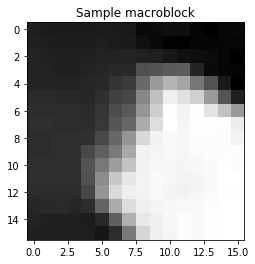

In [11]:
# Print out some statistics about the frames.
import Encoder as e
im_blocks_ref, n_rows, n_cols = e.get_sub_images(e.reshape_image(vid_frame[0][0]))
im_blocks_p, __, __ = e.get_sub_images(e.reshape_image(vid_frame[0][0]))
print('Dimensions of the ref image is ', vid_frame[0][0].shape)
print('Dimensions of the ref divided is', im_blocks_ref.shape)

plt.imshow(im_blocks_ref[1700], "gray")
plt.title("Sample macroblock")

Text(0.5, 1.0, 'Residual frame')

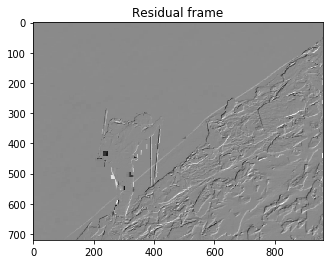

In [77]:
# Print out a sample of the residuals
plt.imshow(residual_frames_y[0], "gray")
plt.title("Residual frame")

## Decode the video

In [29]:
# Inverse Spatial model
quantized_residual_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
quantized_residual_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
quantized_residual_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)
for j in range(0,predictedPerRef-1):
    quantized_residual_y[j] = E.spatial_inverse_model(quantized_coeff_y[j], nrows, ncols, 16)

    quantized_residual_cb[j] =  E.spatial_inverse_model(quantized_coeff_cb[j], nrows, ncols, 8)

    quantized_residual_cr[j] = E.spatial_inverse_model(quantized_coeff_cr[j], nrows, ncols, 8) 
Reconstruced_frames=[]
c=0

# Get predicted image
for j in range(0,np.int(no_frames/predictedPerRef)):
    Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_frames[j])))

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)
    for i in range(0,predictedPerRef-1):
        #inverse spatial
        #residual_blocks, n_rows, n_cols = E.spatial_inverse_model(vid_residuals[c])
        #residual_frame = E.get_reconstructed_image(residual_blocks, n_rows, n_cols)
        mv=vid_mv[c]
        for i in range(mv.shape[0]):
            for j in range(mv.shape[1]):
                mv_cb[i][j][0]=np.int(mv[i][j][0]/2)
                mv_cb[i][j][1]=np.int(mv[i][j][1]/2)
                
        #getting the predicted image
        p_image_y = E.predict(im_ref_y, mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1])
        p_image_cb = E.predict(im_ref_cb, mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1], 8)
        p_image_cr = E.predict(im_ref_cr, mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1], 8)
        
        #adding the residuals to get the reconstructed image
        Reconstructed_y = p_image_y + quantized_residual_y[c]
        Reconstructed_cb = p_image_cb + quantized_residual_cb[c]
        Reconstructed_cr = p_image_cr + quantized_residual_cr[c]

        Reconstructed_interlaced=[Reconstructed_y,Reconstructed_cb,Reconstructed_cr]
        Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(Reconstructed_interlaced)))
        c+=1

## Plotting frames from the reconstructed video

Text(0.5, 1.0, 'last predicted frame')

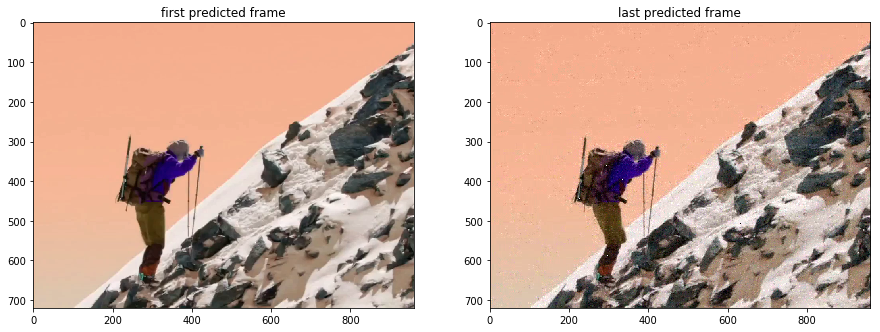

In [56]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,15))

ax1.imshow(Reconstruced_frames[0])
ax1.set_title("first predicted frame")


ax2.imshow(Reconstruced_frames[2])
ax2.set_title("last predicted frame")

In [71]:
# Amount of compression achieved
imarr = e.reshape_image(vid_frame[0][0])

#Compute the number of bits of the np array image
size_before = imarr.size * imarr.itemsize * 8 
print("Size in bits of image before compression: ", size_before)

#size_after = []
#for i in range(len(data)):
#    size_after.append(len(data[i]))
    
#print("Size in bits of image after compression: ", size_after)

Size in bits of image before compression:  5529600


## Analysis

We can notice that the quality of the image deteriorates as the number of predicted images increases. This is expected since the change that happened from frame 1 to 2 is less than the change that happened from frame 1 to frame 5. The ability to predict frames therefore becomes less accurate. To measure the compression ratio for each image, the size of the video is computed in bits by multiplying the size of a single element in the array by the number of elements in the whole image. As for the encoded image, its size was computed by finding the length of the BAC output. The size of the image is then divided by the stream of bits to compute the compression ratio. Moreover, the number of FLOPs was computed by calculating the time for the whole compression operation divided by the time for a single flop.

## Converting the output frames into video

In [46]:
# Save reconstructed images in frames folder

# importing os module   
import os 

# convert the reference frame to RGB
ref_interlaced=[ref_frames[0][0],ref_frames[0][1],ref_frames[0][2]]
ref_frame = E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_interlaced))

# Add the reference frame to the frames folder
filename = "frames/" + str(0) + ".jpg"
cv2.imwrite(filename, ref_frame)

# Add the reconstructed frames to the folder
for c in range(3):
    filename = "frames/" + str(c+1) + ".jpg"
    cv2.imwrite(filename, Reconstruced_frames[c])

In [49]:
# Read the frames in the form of a video
image_folder = 'frames'
video_name = 'output_mountain.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

## Encountered problems

Due to the tremendously large operations that had to be done, we ran into several system crashes and elongated running time. The first problem we encountered was due to python's slow execution of for loops. During motion estimation, 4 nested loops get executed sequentially. This caused the code to run for around 440 seconds to encode just 1 frame. We transferred the code to Julia and the execution time got reduced by 11 times. A single frame code encoded in only 40 seconds. The second problem that we encountered was memory storage. A 16 GB RAM laptop was used to encode 5 frames (1 reference, and 4 predicted). The system crashed due to the memory limitation. We then retried the same operations on a 25 GB RAM on Google Colab, and it still failed to encode. We optimized the code to handle such a problem by deleting all unnecessary arrays regularly. A similar problem occured during the binarization of the data, and it was handled in a similar manner.

BAC has also proved to produce tremendous change in data when the probability gets close to 0.5. To encode the motion vectors and residuals, BAC had to encod 33 million bits. There were instances with probabilities close to 0.5, causing the encoder to misbehave. We decided to perform the video compression process without the BAC to produce reasonable results.





---


<h2 align="center"><font face = "Times New Roman"> Division of work amongst team members</font></h2>






Alaa Roshdy

*   Setting up encoder functions flow
*   Motion Estimation
*   Motion compenstation
*   Spatial model
*   Report
*   Documentation of the above
*   Debugging and testing


Mohamed Adham Mahrous

*   Arithmetic encoding and decoding
*   Binarize and debinarize
*   Documentation of the above
*   Debugging and testing


Mohamed Kasem Saber

*   Get_video_frames
*   Interlace and deinterlace
*   Motion prediction
*   Documentation of the above
*   Debugging and testing


Mohamed Mostafa Hamed

*   Building framework
*   Optimizing code to work on 3 channels YUV
*   Spatial model
*   Report
*   Documentation
*   Debugging and testing
